# Importando as bibliotecas

In [247]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from collections import Counter
import os
import sys
sys.path.insert(0, os.path.abspath('../Util'))
from dados import ProcessarDados
import time

# Dataset

In [254]:
procData = ProcessarDados("../dataset/bin_norm_10_features_m73_n4.csv", sep = ',')

# Funções

In [255]:
# funcção que treina e testa o modelo armazenando as métricas
# retorna um dicionário cotendo os valores das métricas de cada rodada
def treinamento_teste(epocas = 10, k_folds = 5, exibir_matriz_confusao=False, exibir_metricas=False):
    
    #array para armazenar as das métricas de cada rodada
    resultados_accuracy = []
    resultados_precision = []
    resultados_recall = []
    resultados_specificity = [] # taxa de verdadeiros negativos ou especificidade
    resultados_f2 = []
    resultados_parametros = []
    resultados_time_train = []
    resultados_time_test = []
    resultados_time_total = []
    
    #dicionário das métricas
    resultados_gerais = {}

    for i in range(epocas):
        # divisão os dados 
        seed = i
        X_train, X_test, y_train, y_test = procData.holdout2(0.20, seed)
        #print(Counter(y_test))

        # realizando o grid search para encontrar a melhor combinação entre o C, gamma e Kernel, 
        # considerando a acurácia (taxa de acerto)
        # aqui o método GridSearchCV é configurado para subdividir os dados de treino em k_folds
        clf = svm.SVC(random_state = seed)
        grid_svm = GridSearchCV(clf, param_grid, cv=k_folds, scoring='accuracy', verbose=0)
        
        start_time_train = time.clock()
        grid_svm.fit(X_train, y_train)

        # Treinando do modelo com os melhores parametros encontrados
        C_best = grid_svm.best_estimator_.C
        gamma_best = grid_svm.best_estimator_.gamma
        kernel_best = grid_svm.best_estimator_.kernel

        SVM = svm.SVC(random_state = seed, C = C_best, gamma = gamma_best, kernel = kernel_best)
        SVM.fit(X_train, y_train)
        
        time_train = time.clock() - start_time_train

        #testando o modelo
        start_time_test = time.clock()
        y_pred = SVM.predict(X_test)
        time_test = time.clock() - start_time_test
        cm  = confusion_matrix(y_test, y_pred)
        if exibir_matriz_confusao:
            print(cm)

        # calculado as metricas
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        # f2-score
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
        beta = 0.5
        f2_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn+fp)

        # armazenando as métricas
        resultados_accuracy.append(accuracy)
        resultados_precision.append(precision)
        resultados_recall.append(recall)
        resultados_specificity.append(specificity)
        resultados_f2.append(f2_score)

        best_parametros = {"C": C_best, "Gamma": gamma_best, "Kernel": kernel_best};
        resultados_parametros.append(best_parametros)
        
        resultados_time_train.append(time_train)
        resultados_time_test.append(time_test) 
        resultados_time_total.append(time_train+time_test)


        if exibir_metricas:
            print("Rodada: #",i+1)
            print(best_parametros)
            print("Accuracy:",accuracy)
            print("Precision:",precision)
            print("Recall:",recall)
            print("Specificity:",specificity)
            print("f2-Score:",f2_score)
            print("Time Train (s):",time_train)
            print("Time Test (s):",time_test)
            print("Time Total (s):",time_train+time_test)
            print("\n")

            
    resultados_gerais['accuracy'] = resultados_accuracy
    resultados_gerais['precision'] = resultados_precision
    resultados_gerais['recall'] = resultados_recall
    resultados_gerais['specificity'] = resultados_specificity
    resultados_gerais['f2'] = resultados_f2
    resultados_gerais['params'] = resultados_parametros
    resultados_gerais['time_train'] = resultados_time_train
    resultados_gerais['time_test'] = resultados_time_test
    resultados_gerais['time_total'] = resultados_time_total
    
    return resultados_gerais

In [256]:
import csv
def writeResultsCsv(dict_results, name_file):
    keys = list(dict_results.keys())
    keys.insert(0,'Rodada')
    with open(name_file, 'w') as f:  # You will need 'wb' mode in Python 2.x
        w = csv.writer(f)
        #w.writeheader()
        row = []
        w.writerow(keys)
        for i in range(epocas):
            row = []
            acc = dict_results.get('accuracy')[i]
            prec = dict_results.get('precision')[i]
            sen = dict_results.get('recall')[i]
            spe = dict_results.get('specificity')[i]
            fscore = dict_results.get('f2')[i]
            param = dict_results.get('params')[i]
            time_train = dict_results.get('time_train')[i]
            time_test = dict_results.get('time_test')[i]
            time_total = dict_results.get('time_total')[i]

            row.append(i+1)
            row.append(acc)
            row.append(prec)
            row.append(sen)
            row.append(spe)
            row.append(fscore)
            row.append(param)
            row.append(time_train)
            row.append(time_test)
            row.append(time_total)

            w.writerow(row)
    

In [257]:
def tabelaMetricas(nome_modelo, dict_metricas, rodadas=False, salvarResultados=True):
        
    print ("============================================== "+nome_modelo+" =================================================")
    print ("=================================== TABELA DE MÉTRICAS DO MODELO ===================================")
    
    if(rodadas==False):
        print ("\t Accuracy \t|\t Precision \t|\t Recall \t|\tSpecificity \t|\t fb-Score")
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['accuracy'], axis=0), np.std(dict_metricas['accuracy'], axis=0)),end=' ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['precision'], axis=0), np.std(dict_metricas['precision'], axis=0)),end='  ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['recall'], axis=0), np.std(dict_metricas['recall'], axis=0)),end=' ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['specificity'], axis=0), np.std(dict_metricas['specificity'], axis=0)),end='   ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['f2'], axis=0), np.std(dict_metricas['f2'], axis=0)))
        print ("====================================================================================================")
        
    if(salvarResultados):
        # save to npy file
        np.save('../resultados/resultados_'+nome_modelo+'.npy', dict_metricas)
        writeResultsCsv(dict_metricas, 'resultados_svm.csv')

# Definindo os parâmetros

In [258]:
c_range = [10, 20, 30, 40, 50]
gammas = [0.01, 0.02, 0.03, 0.04, 0.05]
kernels = ["rbf"]
param_grid = {'C': c_range, 'gamma': gammas, 'kernel': kernels}

epocas = 50
k_folds = 5
exibir_matriz_confusao = True
exibir_metricas = True
salvarResultados = True
rodadas=False

# Treinando e obtendo as métricas do modelo

In [259]:
# treinando o modelo
dict_metricas = treinamento_teste(epocas, k_folds, exibir_matriz_confusao, exibir_metricas)
tabelaMetricas('SVM',dict_metricas, rodadas, salvarResultados)

[[18  2]
 [ 1 49]]
Rodada: # 1
{'C': 20, 'Gamma': 0.05, 'Kernel': 'rbf'}
Accuracy: 0.9571428571428572
Precision: 0.9607843137254902
Recall: 0.98
Specificity: 0.9
f2-Score: 0.9645669291338583
Time Train (s): 0.7772211999999854
Time Test (s): 0.0009601000001566717
Time Total (s): 0.7781813000001421


[[18  2]
 [ 3 47]]
Rodada: # 2
{'C': 20, 'Gamma': 0.02, 'Kernel': 'rbf'}
Accuracy: 0.9285714285714286
Precision: 0.9591836734693877
Recall: 0.94
Specificity: 0.9
f2-Score: 0.9552845528455283
Time Train (s): 0.546317000000272
Time Test (s): 0.0009038999996846542
Time Total (s): 0.5472208999999566


[[18  2]
 [ 0 50]]
Rodada: # 3
{'C': 30, 'Gamma': 0.05, 'Kernel': 'rbf'}
Accuracy: 0.9714285714285714
Precision: 0.9615384615384616
Recall: 1.0
Specificity: 0.9
f2-Score: 0.9689922480620154
Time Train (s): 0.6305225000014616
Time Test (s): 0.0008730000008654315
Time Total (s): 0.631395500002327


[[17  3]
 [ 2 48]]
Rodada: # 4
{'C': 10, 'Gamma': 0.05, 'Kernel': 'rbf'}
Accuracy: 0.9285714285714286
P

In [233]:
np.mean(dict_metricas['time_total'])

0.6309941580000077

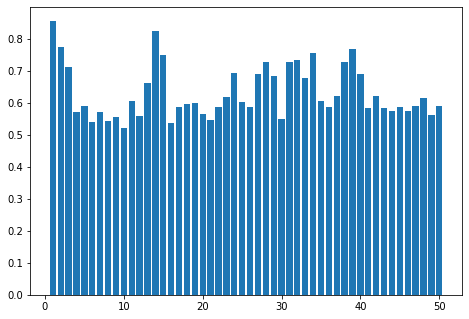

In [246]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = range(1,51,1)
students = [23,17,35,29,12]
ax.bar(langs,dict_metricas['time_total'])
plt.show()